## LangChain vs LangGraph

- LangChain 을 사용했을 때와 LangGraph 를 사용했을 때 어떻게 달라지는지 비교
- 여기는 ollama 를 이용해서 LLM 을 사용

### LangChain

In [1]:
from langchain_ollama import ChatOllama


llm = ChatOllama(model="gpt-oss:20b")

In [2]:
query = "AI Agent 가 뭐야?"
llm.invoke(query)

AIMessage(content='## AI Agent란 무엇인가요?  \n\n### 1️⃣ 정의  \n**AI Agent**는 “환경을 관찰(Perceive) → 판단(Decide/Deliberate) → 행동(Act) → 보상(Reward/Feedback) → 학습(Learn)” 과정을 반복하면서 주어진 목표를 달성하려고 설계된 소프트웨어(또는 하드웨어) 시스템입니다.  \n- **감각(Perception)** : 센서(카메라, 마이크, 데이터 API 등)나 사용자 입력으로부터 정보를 수집  \n- **사고(Decision / Reasoning)** : 수집한 정보를 바탕으로 상태를 이해하고, 목표 달성을 위한 다음 행동을 선택  \n- **행동(Action)** : 선택된 행동을 실행(예: 로봇이 움직이거나, 챗봇이 답변을 전송)  \n- **보상(Reward / Feedback)** : 행동 결과가 얼마나 목표에 부합했는지 평가  \n- **학습(Learning)** : 보상을 이용해 향후 같은 상황에서 더 나은 행동을 선택하도록 모델을 개선\n\n> **요약**  \n> *AI Agent는 자체적으로 **판단**하고 **행동**을 수행하며, 그 결과를 기반으로 **학습**해 스스로를 개선하는 체계입니다.*\n\n---\n\n### 2️⃣ 핵심 특성  \n\n| 특성 | 설명 |\n|------|------|\n| **자율성(Autonomy)** | 외부 명령이 없어도 자체적으로 상황을 판단하고 행동합니다. |\n| **목표지향성(Objective‑driven)** | 명확한 목표(예: ‘방을 청소’, ‘음성인식’)를 달성하려고 노력합니다. |\n| **적응성(Adaptability)** | 환경이 변해도 학습을 통해 새로운 상황에 대응합니다. |\n| **상호작용(Interaction)** | 다른 Agent나 인간과 정보를 교환합니다. |\n| **지식 기반(Knowledge‑based)** | 사전 지식(데이터, 규칙, 모델)을 활용해 판단합니다.

### LangGraph

LangGraph는 상태(State)를 중심으로 노드(Node)와 전이(Edge)로 구성된 단방향 그래프 실행 엔진

#### 핵심 요소

- State: 그래프 전반에 공유되는 상태. 타입 스키마와 병합 규칙(reducer)을 정의해 노드 간 업데이트를 안전하게 합친다.
- Node: 상태를 입력받아 일부 상태를 갱신해 반환하는 **실행 단위**(함수, 도구 호출, 서브그래프/에이전트 등).
- Edge: 한 노드가 끝난 뒤 기본적으로 이어지는 다음 노드를 정의하는 **전이**(조건 없이 항상 그 경로로 이동하는 기본 전이).
- Conditional Edge: _조건 함수의 결과에 따라_ 다음 노드를 동적으로 선택하는 전이(분기/루프 구현에 사용).
- 특수 노드: `__start__` 또는 `START`(시작 노드), `__end__` 또는 `END`(종료). 그래프는 단방향이며, 필요 시 루프를 포함할 수 있다.

#### 간단한 실행 예시 시나리오

목표: 사용자의 대화를 시작하고, 간단한 질문을 한 번 더 던진 뒤 종료하는 플로우

- 초기 상태
  - messages: 빈 리스트
- 노드 구성(개념)
  - greet: “안녕하세요!”와 같은 인사 메시지를 상태에 추가
  - decide: 현재 메시지 수를 보고 계속 진행할지, 종료할지 결정
  - more: “무엇을 도와드릴까요?”와 같은 추가 메시지를 상태에 추가
- 전이(흐름)
  1) `__start__` → greet
     - 동작: 인사 메시지를 상태에 추가
     - 상태 예: messages = ["안녕하세요!"]
  2) greet → decide
     - 동작: 현재 메시지 수를 평가
     - 분기: 메시지가 아직 충분치 않으면 “more”로, 충분하면 종료로
  3) decide → more (조건부)
     - 동작: 추가 질문 메시지를 상태에 누적
     - 상태 예: messages = ["안녕하세요!", "무엇을 도와드릴까요?"]
  4) more → decide
     - 동작: 다시 결정. 이제 메시지 수가 충분하다고 판단되어 종료 선택
  5) decide → `END` (조건부)
     - 동작: 그래프 실행 종료
- 결과 상태(예)
  - messages: ["안녕하세요!", "무엇을 도와드릴까요?"]
  - decision: "done"

포인트
- 루프: decide → more → decide 구간에서 조건이 충족될 때까지 반복할 수 있습니다.
- 상태 병합: 메시지처럼 누적이 필요한 값은 “추가/병합” 규칙을 두면 각 노드의 결과가 안전하게 합쳐집니다.
- 재사용: greet/more 같은 노드는 다른 그래프나 서브그래프에서도 손쉽게 재사용 가능합니다.

In [3]:
from typing import Annotated, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph import add_messages


# Graph 에서 사용할 State 를 정의
class HellogLangGraphState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [4]:
from langgraph.graph import StateGraph


# 정의한 State 를 가질 Graph 생성자를 정의
graph_builder = StateGraph(HellogLangGraphState)

In [5]:
# Node 로 만들어진 함수
def generate(state: HellogLangGraphState) -> HellogLangGraphState:
    messages = state["messages"]
    ai_message = llm.invoke(messages)
    return {"messages": [ai_message]}

In [6]:
# 앞서 정의한 함수를 Node 로 추가
graph_builder.add_node("generate", generate)

In [7]:
from langgraph.graph import END, START


# LangGraph 는 무.조.건. START 로 시작하고, END 로 끝나고 이 Node 가 기본으로 들어있음
# 위에서 추가한 Node 와 START 와 END 를 연결!
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)

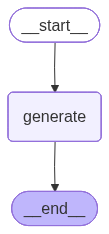

In [8]:
# 최종 Graph 를 만들기!
graph = graph_builder.compile()
graph

In [9]:
from langchain_core.messages import HumanMessage


# LangChain 처럼 invoke 로 실행을 하지만, 우리가 정의한 State 로 값을 넣어주어야 함
initial_state = HellogLangGraphState(messages=[HumanMessage(query)])
graph.invoke(initial_state)

{'messages': [HumanMessage(content='AI Agent 가 뭐야?', additional_kwargs={}, response_metadata={}, id='32cc911b-8b20-449b-b843-3377f49e49b4'),
  AIMessage(content='### AI 에이전트란?  \n\n간단히 말하면 **“목표를 가지고 스스로 판단·행동하는 인공지능 시스템”** 입니다.  \n다음과 같은 핵심 요소를 갖추고 있다고 볼 수 있습니다.\n\n| 핵심 구성요소 | 역할 |\n|--------------|------|\n| **센서 / 인식** | 외부 환경(데이터, 센서, 사용자 입력 등)을 감지합니다. |\n| **추론·학습** | 수집된 정보를 바탕으로 패턴을 인식하거나, 과거 경험을 학습합니다. |\n| **계획 / 의사결정** | 목표 달성을 위해 어떤 행동을 할지 결정합니다. |\n| **액추에이터 / 실행** | 선택한 행동을 실제로 수행합니다. (API 호출, 로봇 움직임, UI 조작 등) |\n| **피드백 루프** | 행동 결과를 다시 인식 단계로 전달해 지속적으로 개선합니다. |\n\n---\n\n## 1. AI 에이전트의 분류\n\n| 종류 | 특징 | 예시 |\n|------|------|------|\n| **반응형(reactive)** | 환경 변화에 즉시 반응; 복잡한 내부 모델이 없음 | 1세대 로봇, 간단한 챗봇 |\n| **지능형( deliberative )** | 상태를 내부적으로 모델링하고 계획을 세워 행동 | 인공지능 비서, 자동 운전 소프트웨어 |\n| **하이브리드** | 반응형과 지능형의 장점을 결합 | 현대 자동차의 운전 보조 시스템 |\n| **멀티 에이전트** | 여러 에이전트가 협력·경쟁하며 문제를 해결 | 물류 로봇 집단, 대규모 시뮬레이션 |\n\n---\n\n## 2. AI 에이전트가 등장한 배경\n\n- **전통적 프로그램**은 *명시적 지시*에 따라 동작합니다.  \n- 